# Ordinary Least Squares Regression

### Summary
In this notebook, the ordinary least squares (OLS) method  will be used to estimate all parameters in a linear regression model. All relevant literature refers to this modeling method as "linear regression" and thus will be referred to as such here. 

This model utilizes (blank) features scraped from [basketball-reference.com](https://www.basketball-reference.com/)'s seasons tables ([totals](https://www.basketball-reference.com/leagues/NBA_2019_totals.html) and [advanced](https://www.basketball-reference.com/leagues/NBA_2019_advanced.html)) and predicts the total fantasy points a player will score the following year, otherwise referred to as __future_fantasy_points__ in the dataset. This metric was calculated following data collection according to [Yahoo's ruleset](https://help.yahoo.com/kb/fantasy-basketball/default-league-settings-fantasy-basketball-sln6919.html). 

It's interesting to note that every iteration of a player is considered separately. For example, 2012 LeBron James is a separate record from 2013 LeBron James. This is to say that 2012 LeBron James' __future_fantasy_points__ attribute is the same as his 2013 total fantasy points attribute, or __fantasy_points__ in the pre-processed data.

While around (blank) records were scraped from basketball-reference, only (blank) records exist in the processed dataset. Consider players who were in the league for only one season. These players do not have __future_fantasy_points__ to predict and thus were dropped during the data-processing phase. Of course, the 2018-2019 season was only used to compute __future_fantasy_points__ for 2017-2018 records. See a subset of the data below.

Note: All data used comes from seasons ending in (blank) to 2019.

In [1]:
import sys
sys.path.append('C:\\Users\\CA015FO\\basketball')
from sqlite import get_data

df = get_data('totals_advanced_nodummies_nonspecific_min41games_normalizedgames_premodel')
df.head()

,two_point_field_goal_percentage,block_percentage,win_shares_per_48_minutes,games_started,win_shares,offensive_rebound_percentage,defensive_rebound_percentage,turnover_percentage,effective_field_goal_percentage,defensive_rebounds,...,points,defensive_win_shares,player_efficiency_rating,three_point_field_goal_percentage,total_rebounds,field_goal_percentage,attempted_two_point_field_goals,free_throw_attempt_rate,offensive_box_plus_minus,future_fantasy_points
0,0.515000,1.800000,0.141000,0.0,3.800000,9.600000,13.500000,15.200000,0.510000,156.0,...,737.0,1.500000,18.700000,0.000000,270.0,0.510000,559.0,0.361,1.7,805.50
1,0.577000,0.300000,0.189000,0.0,10.500000,8.300000,14.000000,13.500000,0.576000,333.0,...,1903.0,1.100000,24.300000,0.000000,516.0,0.576000,1265.0,0.415,5.3,2677.35
2,0.499615,1.384615,0.106308,0.0,2.984615,11.276923,14.930769,14.661538,0.498769,336.0,...,1318.0,1.115385,17.946154,0.205231,605.0,0.498154,1107.0,0.232,1.6,2772.50
3,0.482000,0.100000,0.091000,0.0,4.400000,9.000000,16.700000,16.700000,0.482000,342.0,...,953.0,1.200000,16.600000,0.286000,512.0,0.480000,778.0,0.310,1.4,1652.05
4,0.513000,0.700000,0.091000,0.0,4.000000,2.900000,6.800000,21.400000,0.505000,127.0,...,843.0,1.400000,15.100000,0.158000,184.0,0.503000,637.0,0.337,0.6,1277.65


### Linear Regression
The goal of a linear regression is always the same, in general, and that's to extract a random sample from a population and then to use that random sample to estimate the properties of the population. 

A good question to ask in terms of basketball and this model would be as follows: "By how much does a player's fantasy points next year change for each point scored the year before?" The answer to this question, the weight, is exactly what we're trying to optimize, along with the other (blank) features' weights. 

Below is the linear regression formula, where Y is __future_fantasy_points__ and, in accordance with the example above, $\beta_1$ is the weight attributed to points scored ($x_1$). 

\begin{equation*} Y = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2  +  ...  +  \epsilon \end{equation*}

$\beta_0$, the intercept, and $\epsilon$, the random error, will both be touched on shortly.

### OLS
The name "ordinary least squares" may sound like gibberish to a fresh set of ears, but it actually does a great job of briefly explaining the method's general process. OLS minimizes the sum of the squares of the differences between the observed dependent variable in the dataset and those predicted by the linear function. This is to minimize the differences between the actual __future_fantasy_points__ values and the predicted __future_fantasy_points__ values.

However, the ability to perform minimization doesn't conclude the test as accurate. OLS comes with seven underlying assumptions, six of which must be met by the linear regression in order for the weights to be considered valid.

Most of the assumptions attempt describe the random error, $\epsilon$. Note the word "attempt" here. The random error is truly a random figure that we will never know, as it's a population value that describes the information we don't have.

Thus, in order to assess $\epsilon$ we turn to residuals, or the sample estimate of the error for each observation. Residuals can be calculated as the observed value minus the fitted value, where the observed value in this model is the actual __future_fantasy_points__ figure and the fitted value is the predicted __future_fantasy_points__ figure for a record.

For the remainder of the article, I will go through each OLS assumption one by one and show whether or whether not my model satisfies the assumption.

In [2]:
import statsmodels.api as sm
x = df.iloc[:,:-1]
x_constant = sm.add_constant(x)
y = df['future_fantasy_points']
model = sm.OLS(y, x_constant).fit()

C:\Users\CA015FO\AppData\Local\Continuum\anaconda3\envs\my_env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(-4.628600546143048, 5.098344970559382)

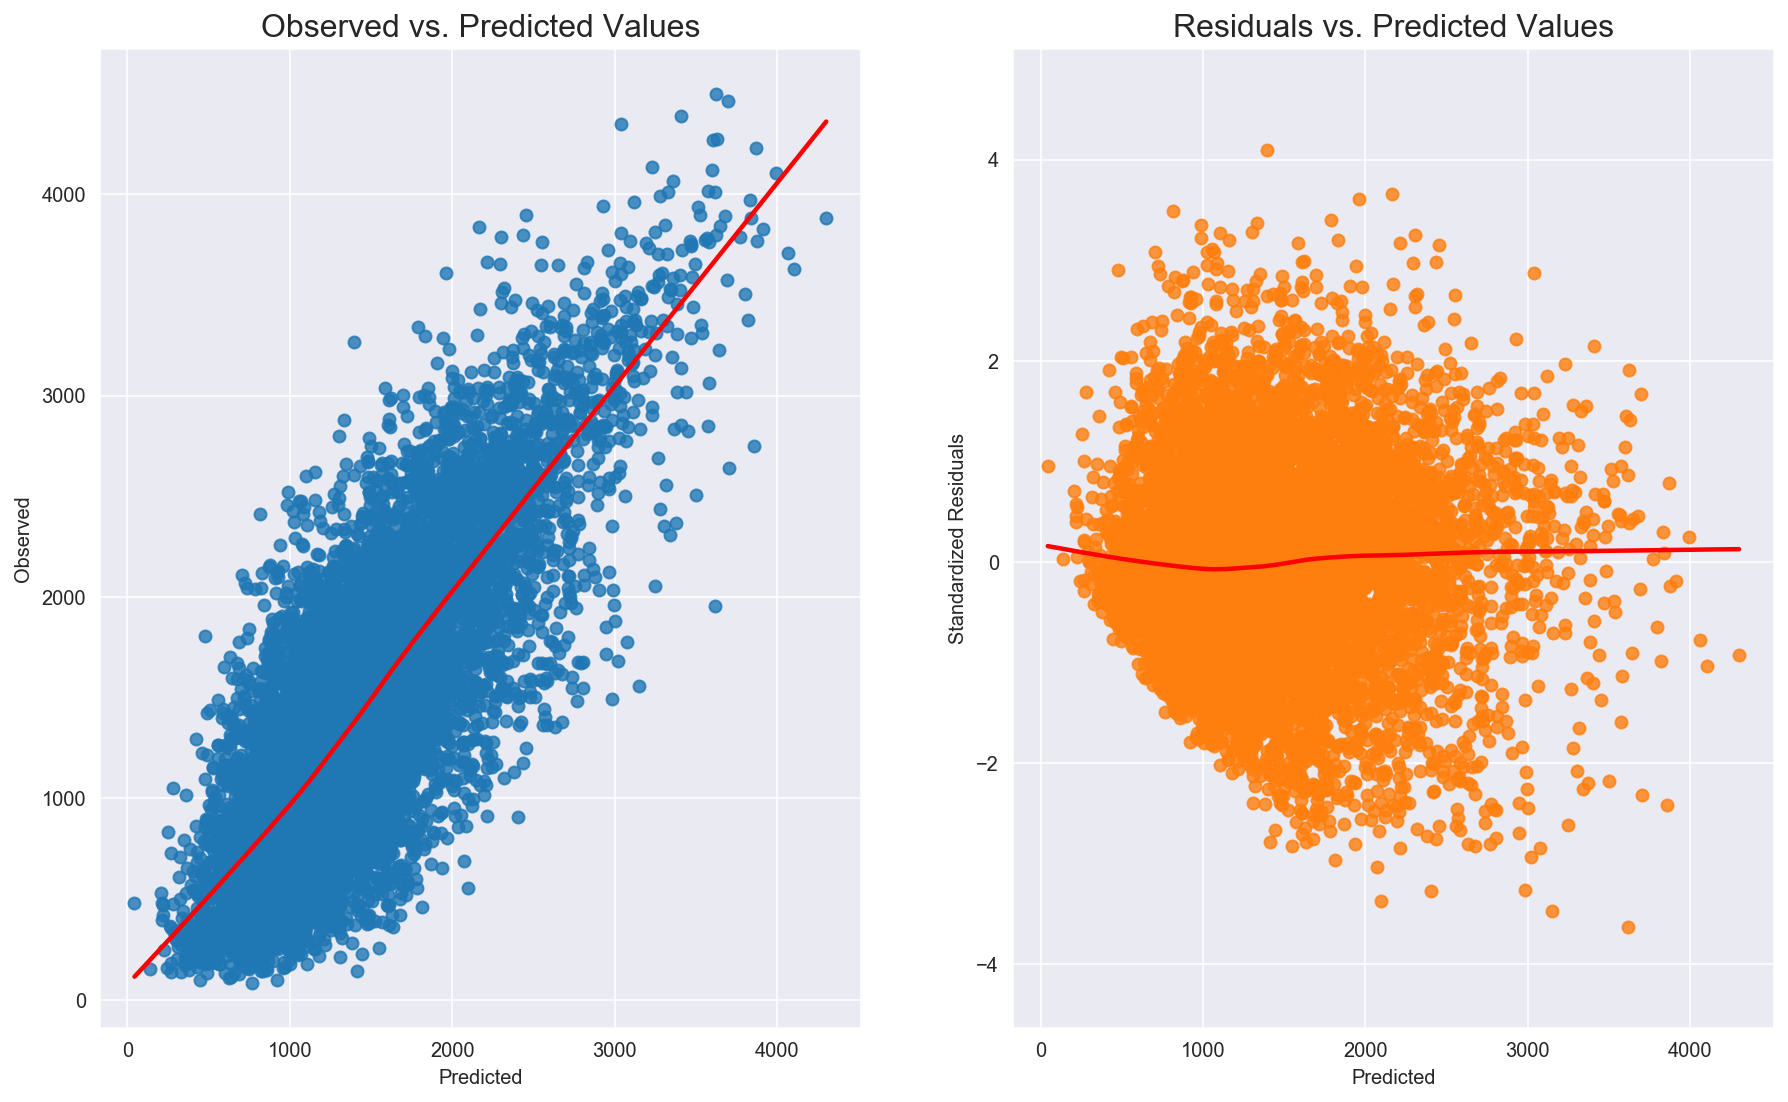

In [3]:
# OLS Assumption 1: The regression model is linear in the coefficients and the error term (linearity of the model)
# Observed vs. Predicted Values should be perfectly diagonal with points equally distributed around it
# Residuals vs. Predicted Values should be perfectly flat with points equally distributed around it

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

# def linearity_test(model, y):
fitted_vals = model.predict()
resids = model.resid_pearson

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color':'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color':'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Standardized Residuals')
ax[1].set_ylim([resids.min()-1, resids.max()+1])

#     return None

# linearity_test(model, y)

In [4]:
# OLS Assumption 2: The error term has a population mean of zero
# Expectation (mean) of residuals is zero
# Our constant makes sure this is 0
model.resid.mean()

5.820381227219042e-11

In [5]:
# No (perfect) multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
vif = [variance_inflation_factor(x_constant.values, i) for i in range(x_constant.shape[1])]
vif_df = pd.DataFrame({'vif':vif[1:]}, index=x.columns)
# vif_df[vif_df['vif'] > 1].sort_values(by='vif', ascending=False)
# vif_df.T['field_goal_percentage']
vif_df.sort_values(by='vif', ascending=False).T

C:\Users\CA015FO\AppData\Local\Continuum\anaconda3\envs\my_env\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,fantasy_points,made_field_goals,made_three_point_field_goals,attempted_field_goals,made_free_throws,offensive_rebounds,turnovers,made_two_point_field_goals,attempted_free_throws,assists,defensive_rebounds,steals,blocks,attempted_three_point_field_goals,points,total_rebounds,attempted_two_point_field_goals,win_shares,box_plus_minus,offensive_win_shares,offensive_box_plus_minus,total_rebound_percentage,defensive_rebound_percentage,field_goal_percentage,defensive_win_shares,defensive_box_plus_minus,effective_field_goal_percentage,offensive_rebound_percentage,three_point_attempt_rate,player_efficiency_rating,true_shooting_percentage,value_over_replacement_player,minutes_played,win_shares_per_48_minutes,usage_percentage,assist_percentage,two_point_field_goal_percentage,steal_percentage,block_percentage,free_throw_attempt_rate,turnover_percentage,free_throw_percentage,personal_fouls,games_started,three_point_field_goal_percentage,age
vif,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,4168.63372,2961.598566,2317.034917,2313.524062,1899.700162,774.556475,684.695676,658.348443,553.373878,495.940921,396.263034,242.522027,112.566976,75.995414,66.878177,49.625332,46.274756,30.071648,26.306989,20.391781,14.223171,13.78857,9.672711,7.700983,6.70213,5.311687,2.876168,2.00465,1.193161


In [6]:
corr_df = df.corr()
corr_df['total_rebounds'].sort_values(ascending=False)

total_rebounds                       1.000000
defensive_rebounds                   0.978379
offensive_rebounds                   0.909324
defensive_rebound_percentage         0.727838
defensive_win_shares                 0.711260
total_rebound_percentage             0.708632
personal_fouls                       0.686094
fantasy_points                       0.684453
blocks                               0.681412
made_two_point_field_goals           0.623025
minutes_played                       0.622701
win_shares                           0.611229
attempted_free_throws                0.600062
attempted_two_point_field_goals      0.588813
made_field_goals                     0.559960
offensive_rebound_percentage         0.559845
games_started                        0.540457
points                               0.535738
made_free_throws                     0.527594
player_efficiency_rating             0.523560
turnovers                            0.502682
future_fantasy_points             

In [7]:
model.params['total_rebounds']

-0.1063806893010702

In [8]:
model.pvalues[model.pvalues > 0.05]

two_point_field_goal_percentage      0.559844
block_percentage                     0.919131
win_shares_per_48_minutes            0.118840
win_shares                           0.570541
offensive_rebound_percentage         0.270066
defensive_rebound_percentage         0.570115
effective_field_goal_percentage      0.235611
defensive_rebounds                   0.366027
free_throw_percentage                0.965970
turnovers                            0.129412
offensive_rebounds                   0.738880
box_plus_minus                       0.670809
made_free_throws                     0.891045
attempted_field_goals                0.118743
assists                              0.215855
made_field_goals                     0.432655
steal_percentage                     0.402160
offensive_win_shares                 0.670864
made_three_point_field_goals         0.847157
made_two_point_field_goals           0.705030
attempted_free_throws                0.183428
steals                            


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  3.890693e+02
p-value                        7.475639e-56
f-value                        9.872866e+00
f p-value                      9.114940e-60

 Goldfeld-Quandt test ----
                value
F statistic  0.909982
p-value      0.999169

 Residuals plots ----


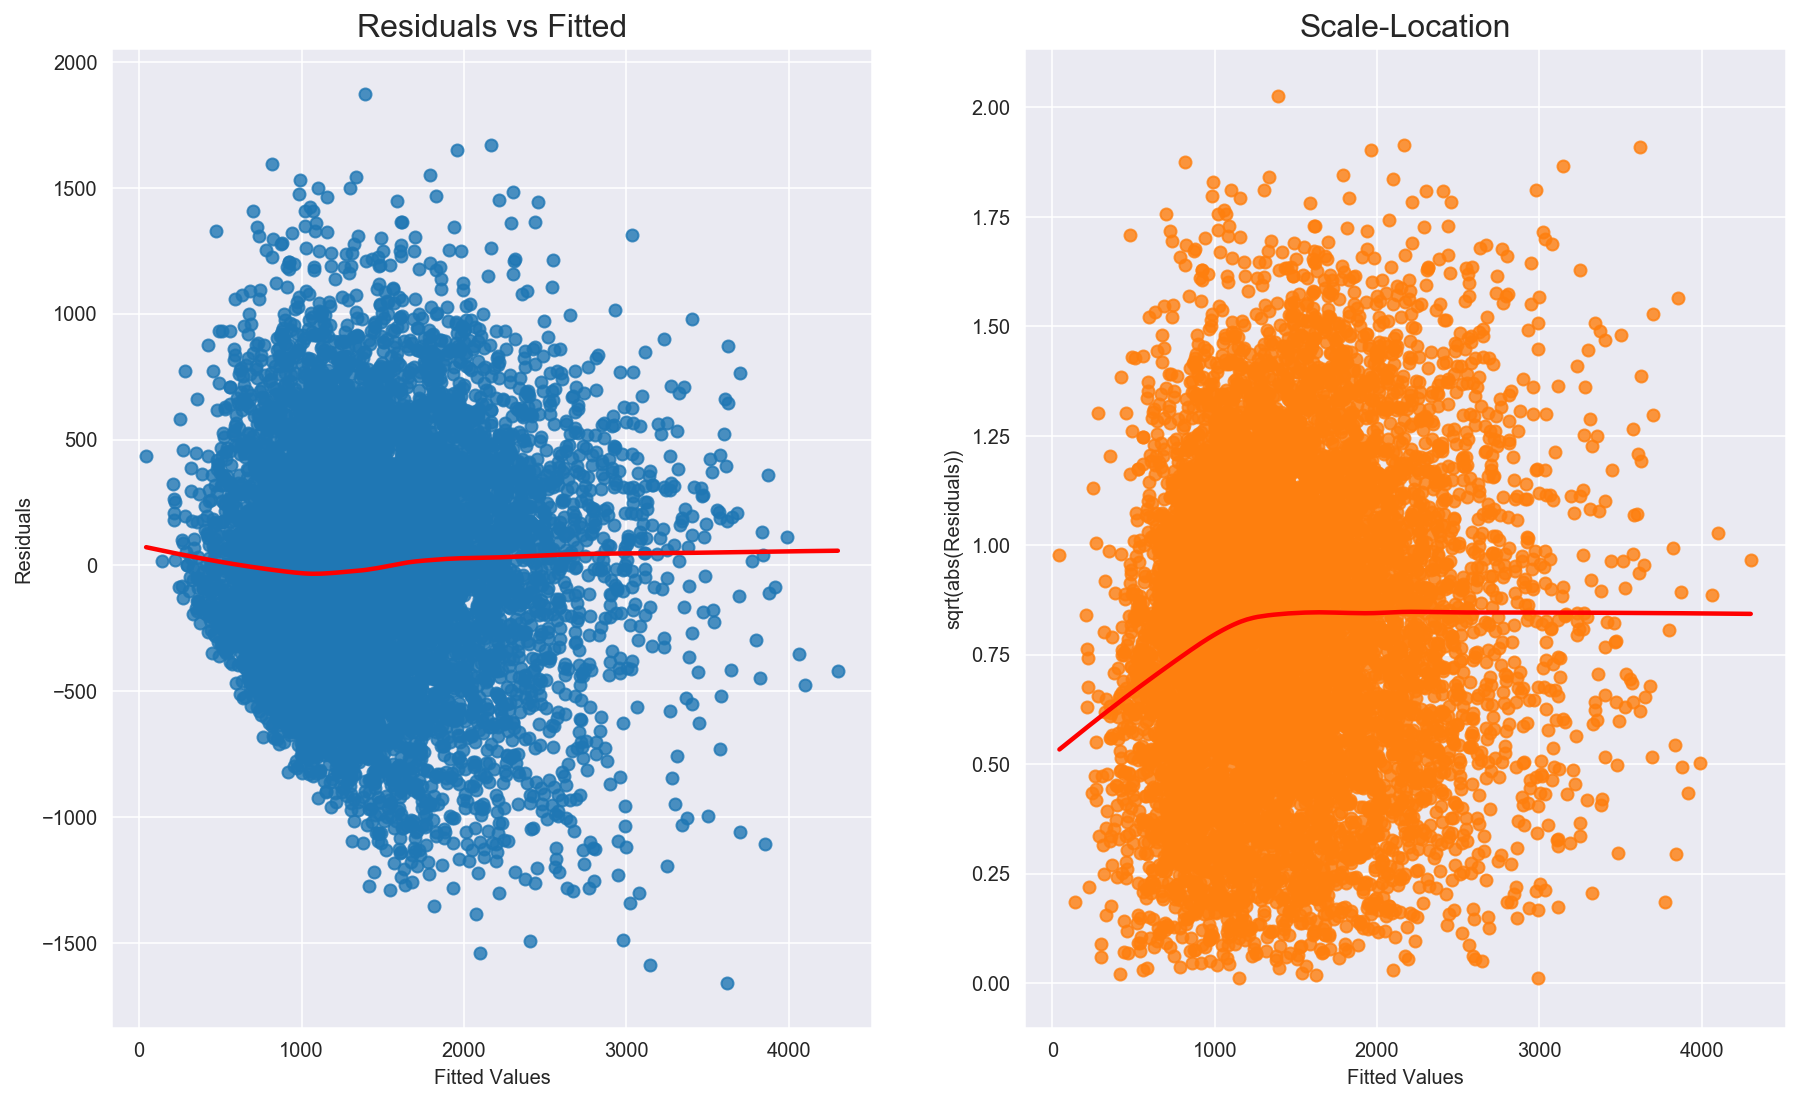

In [9]:
# Homoscedasticity (equal variance) of residuals
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import numpy as np
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(model)

C:\Users\CA015FO\AppData\Local\Continuum\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


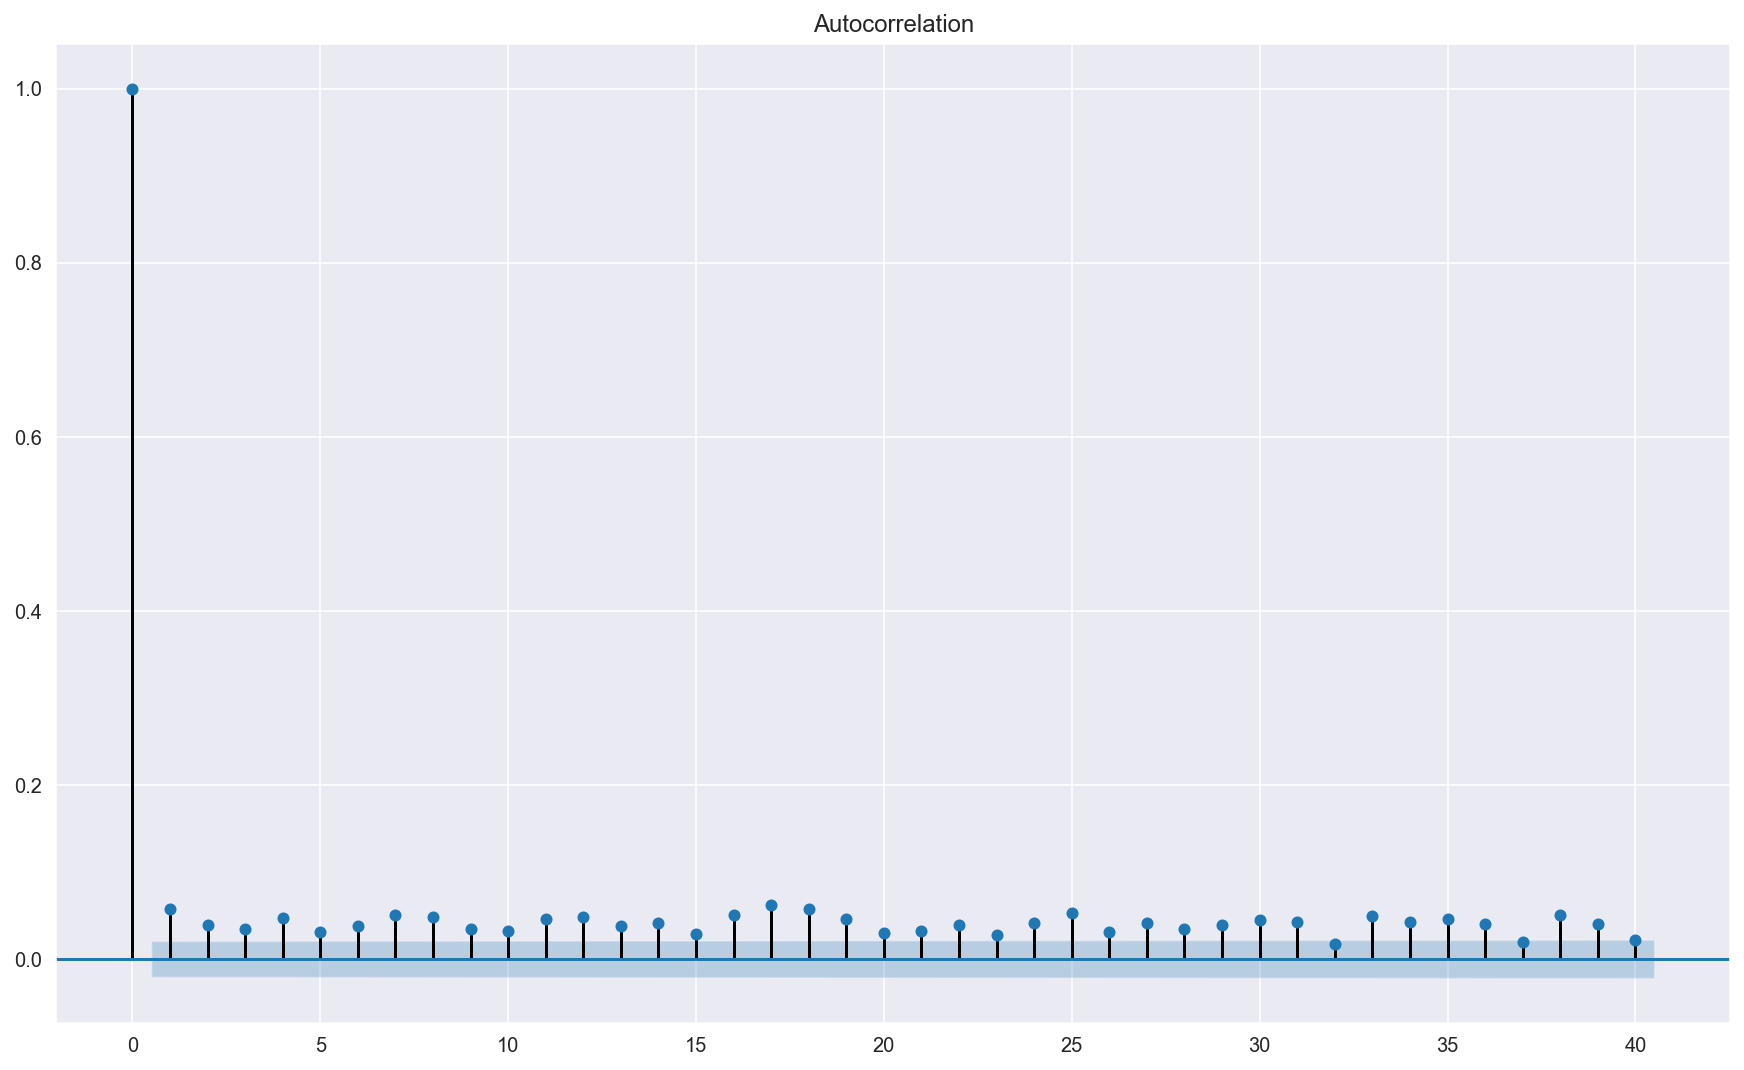

In [10]:
# No autocorrelation of residuals
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05)
acf.show()

In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     future_fantasy_points   R-squared:                       0.624
Model:                               OLS   Adj. R-squared:                  0.622
Method:                    Least Squares   F-statistic:                     361.8
Date:                   Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                           14:39:57   Log-Likelihood:                -67727.
No. Observations:                   8980   AIC:                         1.355e+05
Df Residuals:                       8938   BIC:                         1.358e+05
Df Model:                             41                                         
Covariance Type:               nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                              1806.3218    196.440      9.195      0.000    1421.254    2191.390
two_point_field_goal_percentage     258.4828    443.295      0.583      0.560    -610.477    1127.443
block_percentage                     -1.2066     11.884     -0.102      0.919     -24.501      22.088
win_shares_per_48_minutes           991.4081    635.595      1.560      0.119    -254.503    2237.319
games_started                         1.1698      0.266      4.404      0.000       0.649       1.690
win_shares                           55.6633     98.124      0.567      0.571    -136.682     248.009
offensive_rebound_percentage        -28.2502     25.613     -1.103      0.270     -78.457      21.956
defensive_rebound_percentage        -12.9712     22.841     -0.568      0.570     -57.744      31.801
turnover_percentage                   7.7424      3.494      2.216      0.027       0.893      14.592
effective_field_goal_percentage   -2736.9806   2307.531     -1.186      0.236   -7260.271    1786.309
defensive_rebounds                   -0.2029      0.224     -0.904      0.366      -0.643       0.237
free_throw_percentage                -5.3601    125.634     -0.043      0.966    -251.632     240.912
personal_fouls                       -0.9692      0.177     -5.491      0.000      -1.315      -0.623
value_over_replacement_player       -78.3779     24.540     -3.194      0.001    -126.481     -30.275
turnovers                             0.6162      0.406      1.517      0.129      -0.180       1.413
offensive_rebounds                    0.0965      0.289      0.333      0.739      -0.471       0.664
box_plus_minus                       41.8463     98.450      0.425      0.671    -151.138     234.830
made_free_throws                      0.0706      0.516      0.137      0.891      -0.940       1.081
attempted_field_goals                -0.3171      0.203     -1.560      0.119      -0.716       0.081
usage_percentage                     21.2654      5.498      3.868      0.000      10.487      32.044
assists                              -0.2926      0.236     -1.238      0.216      -0.756       0.171
made_field_goals                      0.1156      0.147      0.785      0.433      -0.173       0.404
minutes_played                       -0.2047      0.046     -4.404      0.000      -0.296      -0.114
steal_percentage                    -22.7395     27.142     -0.838      0.402     -75.943      30.464
offensive_win_shares                -41.8346     98.440     -0.425      0.671    -234.799     151.130
age                                 -31.4878      1.380    -22.814      0.000     -34.193     -28.782
made_three_point_field_goals         -0.1100      0.571     -0.193      0.847      -1.229   